Importing Libraries

# Handwritten Digits Recognizer Using Two (2) - Layer Neural Network

In this notebook, I built a basic two-layer neural network from scratch. I trained it on the MNIST handwritten digits dataset. The main goal was to understand the math behind neural networks:

- Forward and backward propagation
- Activations
- Loss functions
- Gradient updates

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import sklearn


Loading Train Data

In [3]:
train = pd.read_csv("train.csv")


Loading Test Data

In [4]:
test = pd.read_csv("test.csv")



Data Visualization

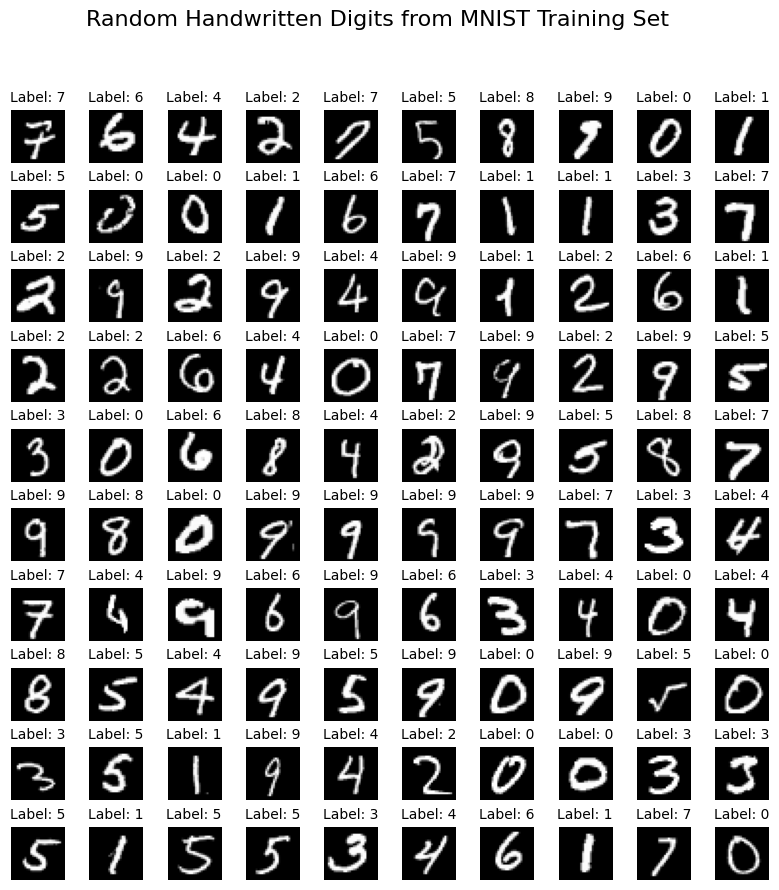

In [5]:
# Visualize 10x10 random digits from the training set
rows = 10
cols = 10
fig = plt.figure(figsize=(10, 10))  # Larger figure for better visibility

# Randomly select 100 examples
indexes = np.random.choice(len(train), rows * cols, replace=False)

count = 0
for i in range(rows):
    for j in range(cols):
        idx = indexes[count]
        ax = fig.add_subplot(rows, cols, count + 1)
        
        # Extract the pixel values and reshape to 28x28
        pixels = train.iloc[idx, 1:].values  # Skip the 'label' column
        pixels = pixels.reshape(28, 28)
        
        ax.imshow(pixels, cmap='gray')
        ax.set_title(f"Label: {train.iloc[idx, 0]}", fontsize=10)
        ax.axis('off')
        
        count += 1

plt.subplots_adjust(wspace=0.1, hspace=0.5)  # Space for titles
plt.suptitle("Random Handwritten Digits from MNIST Training Set", fontsize=16)
plt.show()

Checking First and last Five Rows of Train set

In [7]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
train.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train.shape

(42000, 785)

In the Table:

Row = number of examples (samples / images) (m)

Column = number of features (n)

Covert Data To Numpy Array & Shuffle it

In [10]:
data = np.array(train)

In [11]:
m, n = data.shape

Data is shuffled to prevent the model from learning false patterns caused by order

In [12]:
np.random.shuffle(data)

Split data into Val set and Train set and Transpose

In [13]:
data_dev = data[0:1000,:].T   # Take first 1000 examples, then transpose
Y_dev = data_dev[0]         # First row after transpose → labels
X_dev = data_dev[1:]       # Rest of rows → pixels

In [14]:
X_dev.shape

(784, 1000)

In [15]:
Y_dev.shape

(1000,)

In [16]:
data_train = data[1000:m,:].T
Y_train = data_train[0]
X_train = data_train[1:]


In [17]:
X_train.shape

(784, 41000)

Initialize Paramaters 

In [18]:
def init_param(n_input, n_hidden, n_output):
    """
    Initialize weights and biases for a 2-layer neural network.
    
    Args:
        n_input: number of input features
        n_hidden: number of neurons in hidden layer
        n_output: number of output neurons/classes
    
    Returns:
        W1, b1, W2, b2: initialized parameters
    """
    # Input → Hidden
    W1 = np.random.randn(n_hidden, n_input) * 0.1  
    b1 = np.zeros((n_hidden, 1))       
                
    # Hidden → Output
    W2 = np.random.randn(n_output, n_hidden) * 0.1
    b2 = np.zeros((n_output, 1))
    
    return W1, b1, W2, b2


Defining Variables


In [19]:
n_input = n
n_hidden = 10
n_output = 10

In [20]:
W1, b1, W2, b2 = init_param(n_input, n_hidden, n_output)

print("W1:", W1.shape)
print("b1:", b1.shape)
print("W2:", W2.shape)
print("b2:", b2.shape)


W1: (10, 785)
b1: (10, 1)
W2: (10, 10)
b2: (10, 1)


Activation Functions

In [7]:
def relu(Z):
    """
    Z: numpy array of shape (n_output, m), m = number of examples
    Returns: softmax probabilities of same shape
    """
    return np.maximum(0,Z)


def softmax(Z):
    """
    Z: numpy array of shape (n_output, m), m = number of examples
    Returns: softmax probabilities of same shape
    """
    return np.exp(Z)/np.sum(np.exp(Z))

Forward Propagation

In [8]:
def forward_prop(W1, b1, W2, b2, X):
    """
    W1, b1: weights and biases for layer 1
    W2, b2: weights and biases for layer 2
    X: input data of shape (n_input, m)
    
    Returns:
        A2: output probabilities of shape (n_output, m)
        cache: dictionary containing intermediate values for backprop
    """
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2
    }
    
    return A2, cache


Backpropagation